# **Perkenalan**

Nama    : Iriel Aureleo

Batch   : HCK-027

Objective   : Project ini dilakukan dengan membangun model klasifikasi sentimen headline berita financial menggunakan Artificial Neural Network (ANN) untuk mengelompokkan teks ke dalam kategori negative, neutral, atau positive. Model baseline ini dievaluasi menggunakan metrik f1-score dan confusion matrix untuk mengukur keseimbangan performa antar kelas. Selanjutnya, dilakukan proses model improvement guna meningkatkan akurasi dan generalisasi model terhadap data baru.

# **Import Libraries**

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
import unicodedata
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import confusion_matrix

# **Data Loading**

## Preview dataset

In [36]:
# Load data
data = pd.read_csv('data (1).csv')
data

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


Berdasarkan hasil preview lima baris pertama dan terakhir dari dataset, dapat disimpulkan bahwa data terdiri atas dua kolom utama, yaitu `Sentence` yang berisi kutipan teks dari berita atau laporan finansial, dan `Sentiment` yang merupakan label sentimen dari masing-masing teks, terdiri dari tiga kategori: **positive**, **negative**, dan **neutral**. Teks yang ditampilkan memiliki struktur kalimat yang sesuai dengan gaya bahasa media keuangan, dengan beberapa mencantumkan simbol pasar seperti `$ESI`, yang menunjukkan relevansi data terhadap konteks investasi. Dari baris-baris awal dan akhir, terlihat bahwa ketiga label sentimen muncul secara representatif, mengindikasikan bahwa dataset ini cocok untuk tugas klasifikasi multikelas dalam analisis sentimen. Struktur data yang bersih dan langsung pada konteks finansial membuat dataset ini sangat sesuai digunakan untuk membangun model NLP yang bertujuan mengidentifikasi persepsi pasar terhadap isu financial secara otomatis.

## Cek dimensi datase

In [37]:
# Cek dimensi dataset
data.shape

(5842, 2)

Dataset memiliki **5.842 baris** dan **2 kolom**, yang menunjukkan terdapat 5.842 kalimat atau entri teks finansial yang masing-masing sudah diberi label sentimen. Ini merupakan jumlah yang cukup representatif untuk digunakan dalam pelatihan model NLP klasifikasi sentimen.

## Cek tipe data

In [38]:
# Cek tipe data dan informasi ringkas dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Hasil menunjukkan bahwa dataset terdiri dari 2 kolom bertipe data object, yaitu `Sentence` dan `Sentiment`. Kedua kolom ini memiliki jumlah **entri lengkap (tidak ada missing values)** sebanyak 5.842 baris. Kolom `Sentence` berisi teks kalimat dalam bentuk **string**, sedangkan `Sentiment` adalah label kategorikal juga dalam format **string**. Ini berarti data siap digunakan tanpa perlu penanganan missing value pada tahap awal

## Cek data duplikat

In [39]:
data.duplicated().sum() 

6

Terdapat 6 baris duplikat dalam dataset. Duplikasi ini nantinya akan dihapus untuk menghindari bias dalam pelatihan model, terutama karena duplikat bisa memperkuat representasi kalimat tertentu secara tidak proporsional.

### Handling duplikat data

Sebelum dilanjutkan ke proses selanjutnya akan dilakukan penghapusan duplikat data

In [40]:
# duplikat dataset 
df = data.copy()

Dilakukan duplikasi data terlebih dahulu untuk membuat salinan cadangan (backup) agar data asli tetap aman dan tidak mengalami perubahan saat proses analisis.

In [41]:
# Hapus baris duplikat dari dataset
df = df.drop_duplicates()

# Mengecek data duplikat
df.duplicated().sum()

0

Data duplikat berhasil dihapus.

# **Exploratory Data Analysis (EDA)**

## 1. Distribusi Label Sentimen

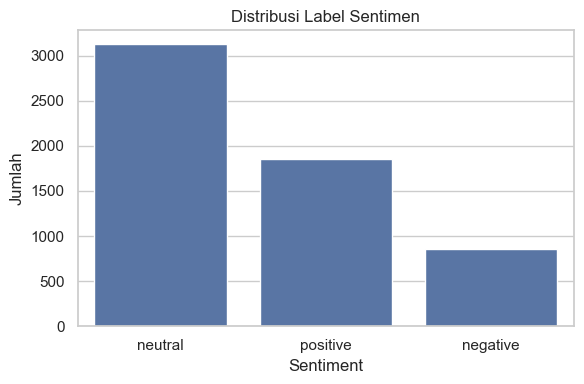

Sentiment
neutral     53.53
positive    31.73
negative    14.74
Name: proportion, dtype: float64

In [42]:
# Set style visualisasi
sns.set(style="whitegrid")

# Plot distribusi label sentimen
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index)
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# Hitung persentase distribusi
label_distribution = df['Sentiment'].value_counts(normalize=True) * 100
label_distribution.round(2)

Berikut hasil distribusi label sentimen dalam dataset:

- Neutral: 53,53%

- Positive: 31,73%

- Negative: 14,74%

Distribusi ini menunjukkan bahwa data bersifat **imbalanced**, dengan dominasi kelas neutral. Ketidakseimbangan ini dapat menyebabkan model bias terhadap kelas mayoritas dan mengabaikan prediksi kelas minoritas. Oleh karena itu, strategi penanganan yang paling tepat dan efisien dalam konteks proyek ini adalah menggunakan **class weighting** saat proses pelatihan model. Metode ini memberikan bobot lebih besar kepada kelas yang jumlahnya lebih sedikit, tanpa mengubah struktur data aslinya.

Class weighting sangat cocok untuk kasus klasifikasi teks seperti ini karena didukung langsung oleh TensorFlow, aman dari risiko overfitting yang sering muncul pada metode oversampling, dan mudah diimplementasikan. Dengan pendekatan ini, model dapat belajar secara lebih seimbang dan menghasilkan prediksi yang adil terhadap semua kelas sentimen.

## 2. Distribusi Panjang Teks (Jumlah Kata & Karakter)

Pada tahap ini, dilakukan eksplorasi terhadap panjang masing-masing teks berdasarkan jumlah kata (`word_count`) dan jumlah karakter (`char_count`). Analisis ini bertujuan untuk memahami karakteristik umum dari struktur kalimat dalam data, seperti apakah mayoritas teks bersifat singkat, menengah, atau panjang. Informasi ini penting sebagai acuan dalam menentukan parameter teknis pada tahap preprocessing, khususnya dalam menentukan nilai maksimum panjang input (`max_len`) untuk proses tokenisasi dan padding saat model dilatih.

In [43]:
# Tambahkan kolom panjang teks berdasarkan jumlah kata dan karakter
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['Sentence'].apply(lambda x: len(str(x)))

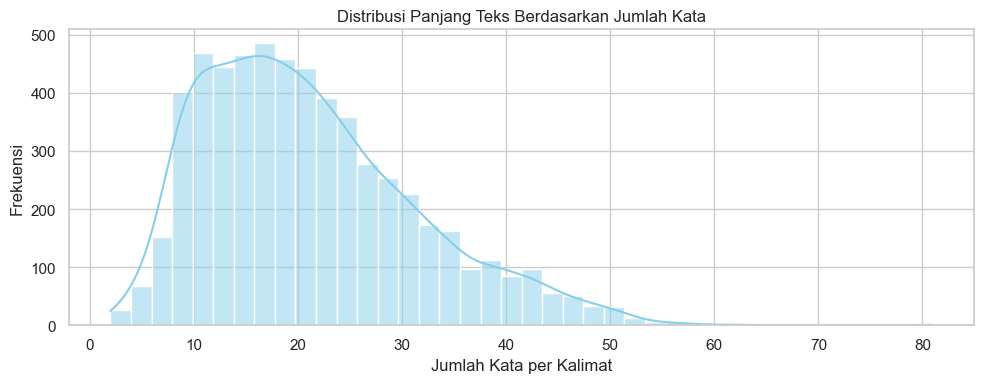

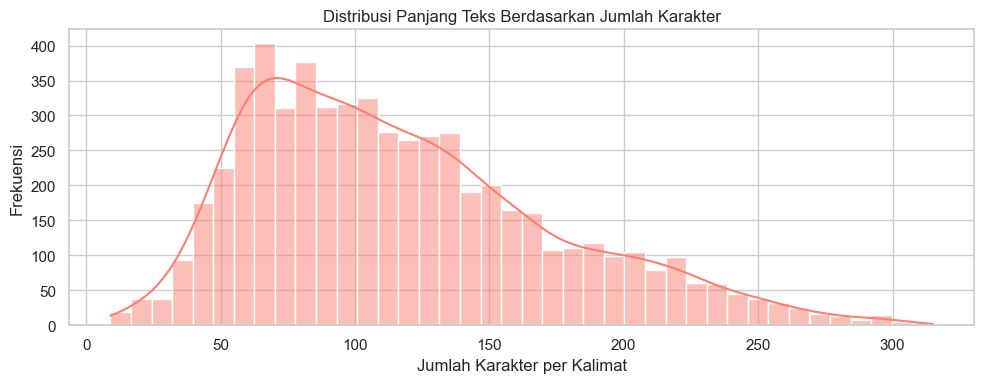

In [44]:
# Visualisasi distribusi panjang teks (jumlah kata)
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=40, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks Berdasarkan Jumlah Kata')
plt.xlabel('Jumlah Kata per Kalimat')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Visualisasi distribusi panjang teks (jumlah karakter)
plt.figure(figsize=(10, 4))
sns.histplot(df['char_count'], bins=40, kde=True, color='salmon')
plt.title('Distribusi Panjang Teks Berdasarkan Jumlah Karakter')
plt.xlabel('Jumlah Karakter per Kalimat')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

Dari hasil tersebut didapatkan :

**Jumlah Kata (Word Count):**

- Mayoritas teks memiliki panjang antara 10 hingga 50 kata.

- Terdapat puncak distribusi di sekitar 20–30 kata, menunjukkan panjang kalimat yang cukup ringkas namun informatif.

- Distribusinya sedikit skewed ke kanan, artinya ada sebagian teks yang lebih panjang dari rata-rata.

**Jumlah Karakter (Character Count):**

- Sebagian besar teks berada dalam rentang 50–250 karakter.

- Distribusi juga menunjukkan kecenderungan ke arah kalimat dengan panjang sedang, cukup umum untuk teks berita finansial.

Berdasarkan distribusi ini, didapatkan bahwa untuk panjang maksimum (`max_len`) bisa memilih sekitar 50 kata saat melakukan padding untuk model NLP. Kalimat ekstrem yang terlalu panjang bisa di-truncate, sementara yang lebih pendek akan di-pad.

## 3. Statistik Deskriptif Panjang Teks per Label (Avg / Min / Max Token)

Sebelumnya telah dianalisis distribusi panjang teks secara umum. Namun untuk memahami lebih dalam karakteristik teks pada masing-masing sentimen, dilakukan juga analisis statistik deskriptif secara terpisah per label.

In [45]:
# Statistik deskriptif panjang teks (jumlah kata) per kategori sentimen
stats_by_label = df.groupby('Sentiment')['word_count'].agg(['mean', 'min', 'max', 'std']).round(2)
stats_by_label

,mean,min,max,std
Sentiment,,,,
negative,19.26,2,56,10.26
neutral,22.12,2,81,9.97
positive,19.90,2,57,10.60


Analisis statistik deskriptif menunjukkan bahwa panjang rata-rata teks berbeda antar kategori sentimen. Teks dengan sentimen neutral memiliki panjang rata-rata tertinggi, yaitu 22,12 kata per kalimat, dengan panjang maksimum mencapai 81 kata. Hal ini menunjukkan bahwa teks netral dalam berita financial cenderung bersifat lebih deskriptif dan informatif. Di sisi lain, teks dengan sentimen negative dan positive memiliki panjang rata-rata yang lebih pendek, masing-masing 19,26 dan 19,90 kata, dengan panjang maksimum 56 dan 57 kata. Meskipun keduanya lebih ringkas dibandingkan teks netral, keduanya tetap menunjukkan variasi yang cukup besar sebagaimana terlihat dari standar deviasi di atas 10. Temuan ini menunjukkan bahwa teks yang mengandung opini emosional (baik positif maupun negatif) dalam konteks keuangan lebih sering disampaikan secara padat dan langsung, sementara teks netral cenderung menjabarkan informasi secara lebih rinci. Insight ini memberikan gambaran awal tentang gaya penyampaian masing-masing sentimen yang dapat memengaruhi proses pelabelan dan klasifikasi model NLP.


## 4. Visualisasi WordCloud per Kategori Sentimen

Untuk menggali lebih dalam karakteristik bahasa dari masing-masing kategori sentimen, dilakukan visualisasi WordCloud. Visualisasi ini menampilkan kata-kata yang paling sering muncul dalam kalimat berlabel positive, negative, dan neutral. Sebelum membuat WordCloud, kata-kata umum yang tidak memiliki makna spesifik (stopwords) dihilangkan agar hanya kata-kata bermakna yang ditampilkan. Tujuan dari tahap ini adalah untuk mengidentifikasi kata-kata kunci yang paling mencolok di masing-masing kategori dan melihat bagaimana perbedaan penggunaan bahasa antara sentimen positif, negatif, dan netral dalam konteks berita finansial.

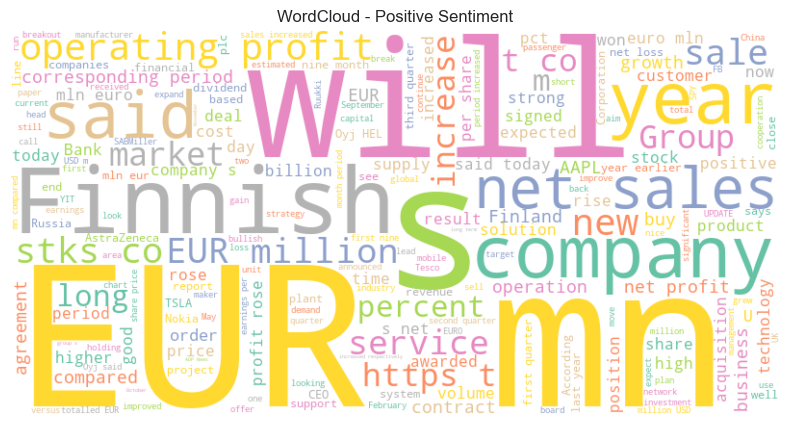

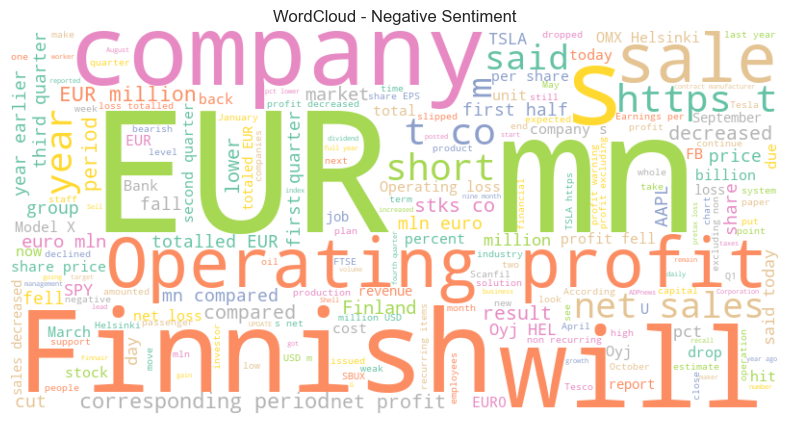

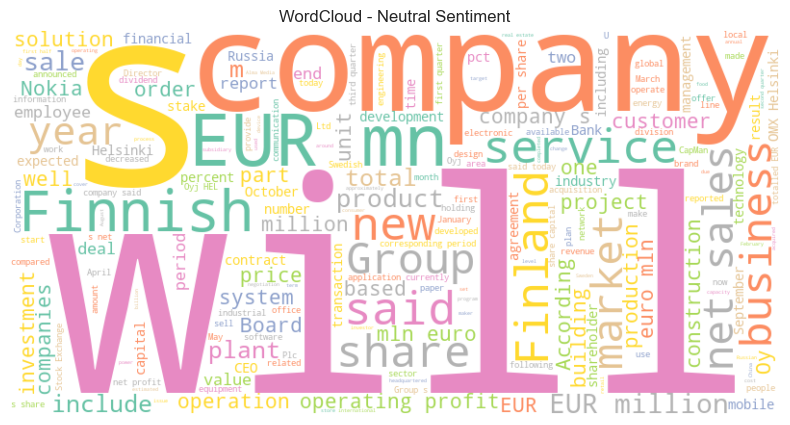

In [46]:
def generate_wordcloud_clean_simple(sentiment_label, df):
    text = ' '.join(df[df['Sentiment'] == sentiment_label]['Sentence'].astype(str))
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS,  # gunakan stopwords bawaan
        colormap='Set2'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {sentiment_label.capitalize()} Sentiment')
    plt.show()

# Generate WordCloud bersih dari stopwords untuk setiap label
for label in df['Sentiment'].unique():
    generate_wordcloud_clean_simple(label, df)

**Neutral Sentiment**  

Dominasi kata seperti *company*, *said*, *share*, *service*, *group*, *business*, dan *market*. Kata-kata ini bersifat informasional dan cenderung netral secara emosional—mengindikasikan bahwa kalimat netral dalam berita keuangan biasanya menyampaikan informasi faktual, seperti pernyataan perusahaan atau laporan operasional.

**Negative Sentiment**

Muncul kata-kata seperti *decreased*, *loss*, *lower*, *declined*, *cut*, *fell*, *short*, dan *drop*. Ini menunjukkan nuansa penurunan kinerja atau risiko, yang umum ditemukan dalam laporan kerugian, pemangkasan produksi, atau berita krisis keuangan. Kata-kata tersebut menjadi indikator kuat sentimen negatif dalam konteks keuangan.

**Positive Sentiment**

Kata-kata seperti *increase*, *growth*, *profit*, *acquisition*, *higher*, *improve*, dan *successful* banyak muncul. Menunjukkan optimisme dan pencapaian keuangan, mencerminkan peristiwa atau laporan yang mengindikasikan perkembangan positif bagi perusahaan, seperti pertumbuhan penjualan, laba bersih, dan ekspansi bisnis.

WordCloud yang telah dibersihkan dari stopwords memperjelas perbedaan pola bahasa antar kategori sentimen. Kata-kata khas pada masing-masing label memberikan bukti bahwa setiap sentimen memiliki karakteristik leksikal yang berbeda, yang dapat dimanfaatkan sebagai sinyal utama dalam pelatihan model klasifikasi berbasis teks.

# **Feature Engineering**

## Data Preprocessing

### Case Folding

Case folding adalah proses mengubah semua huruf dalam teks menjadi huruf kecil (*lowercase*). Tujuannya adalah untuk memastikan konsistensi representasi kata, sehingga model tidak menganggap kata seperti Profit, profit, dan PROFIT sebagai tiga entitas yang berbeda.

In [47]:
# Terapkan case folding (lowercasing)
df['lower_text'] = df['Sentence'].str.lower()

# Tampilkan 5 baris pertama sebelum dan sesudah lowercasing
comparison = df[['Sentence', 'lower_text']].head()
comparison

,Sentence,lower_text
0,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...","$esi on lows, down $1.50 to $2.50 bk a real po..."
2,"For the last quarter of 2010 , Componenta 's n...","for the last quarter of 2010 , componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,according to the finnish-russian chamber of co...
4,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...


Dari hasil ini terlihat bahwa semua huruf kapital telah dikonversi menjadi huruf kecil. Hal ini memungkinkan model membaca teks dengan representasi yang lebih bersih dan konsisten.

### Cleaning

Pada tahap ini, dilakukan proses cleaning untuk membersihkan data text dan menghapus karakter non-alfabetik seperti angka, tanda baca, dan simbol (misalnya `$`, `%`, atau angka tahun). Meskipun data berupa headline berita financial yang secara alami mengandung angka dan simbol penting, karakter-karakter tersebut tetap dihapus karena tokenizer standar yang digunakan (dari TensorFlow Keras) tidak memiliki kemampuan untuk memahami makna numerik atau simbolis dari token tersebut. Angka seperti `3`, `30`, atau `2023` akan dianggap sebagai token literal tanpa konteks nilai atau besaran, sehingga justru dapat menambah noise dan memperbesar jumlah vocabulary yang tidak bermakna.

Selain itu, makna sentimen dalam berita finansial biasanya justru terletak pada kata-kata seperti *increase*, *loss*, *drop*, *growth*, atau *decline*, bukan pada angka atau simbol itu sendiri. Oleh karena itu, menghapus angka dan simbol tidak menghilangkan informasi utama yang dibutuhkan model untuk mengenali sentimen. Langkah ini justru menyederhanakan struktur input agar model dapat fokus belajar dari kata-kata yang benar-benar merepresentasikan polaritas emosi atau kondisi pasar yang ingin diklasifikasikan.

In [ ]:
# Fungsi cleaning lanjutan
def advanced_cleaning(text):
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'\S+@\S+', '', text)  # Hapus email
    text = re.sub(r'http\S+|www\S+', '', text)  # Hapus URL
    text = re.sub(r'\brt\b', '', text)  # Hapus 'retweet' (rt)
    text = re.sub(r'<.*?>', '', text)  # Hapus HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca (punctuation)
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    
    # Hapus karakter beraksen
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    
    return text

# Terapkan ke data
df['clean_text'] = df['lower_text'].apply(advanced_cleaning)

df[['lower_text', 'clean_text']].head()

,lower_text,clean_text
0,the geosolutions technology will leverage bene...,the geosolutions technology will leverage bene...
1,"$esi on lows, down $1.50 to $2.50 bk a real po...",esi on lows down to bk a real possibility
2,"for the last quarter of 2010 , componenta 's n...",for the last quarter of componenta s net sales...
3,according to the finnish-russian chamber of co...,according to the finnishrussian chamber of com...
4,the swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...


### Stop Words 

Tahap stopword removal dalam preprocessing teks bertujuan untuk menghapus kata-kata umum yang tidak memiliki makna khusus atau kontribusi signifikan terhadap analisis sentimen. Kata-kata seperti *the*, *is*, and, *from*, dan *at* sering disebut sebagai **stopwords**, yaitu kata-kata yang secara statistik paling sering muncul dalam teks, tetapi tidak membedakan antara satu label sentimen dengan lainnya. Meskipun pada tahap eksplorasi sebelumnya (seperti WordCloud) stopwords sudah dihapus untuk keperluan visualisasi, penghapusan tersebut hanya bersifat sementara dan tidak mengubah data asli. 

Oleh karena itu, penghapusan stopwords secara struktural dalam dataset perlu dilakukan agar model dapat dilatih menggunakan teks yang lebih bermakna secara semantik. Dampak dari proses ini adalah mengurangi noise dalam data, memperkecil ukuran vocabulary, serta membantu model fokus pada kata-kata penting yang benar-benar merepresentasikan polaritas sentimen. 

In [ ]:
# Set stopword Bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Terapkan ke kolom clean_text
df['no_stopwords'] = df['clean_text'].apply(remove_stopwords)

df[['clean_text', 'no_stopwords']].head()

,clean_text,no_stopwords
0,the geosolutions technology will leverage bene...,geosolutions technology leverage benefon gps s...
1,esi on lows down to bk a real possibility,esi lows bk real possibility
2,for the last quarter of componenta s net sales...,last quarter componenta net sales doubled eurm...
3,according to the finnishrussian chamber of com...,according finnishrussian chamber commerce majo...
4,the swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining percent sta...


### Lemmatization

Pada tahap preprocessing ini, dilakukan proses lemmatization menggunakan library `spaCy`, salah satu NLP library paling canggih dan efisien untuk pemrosesan bahasa alami. Tidak seperti stemming yang hanya memotong kata berdasarkan aturan heuristik tanpa memperhatikan konteks, lemmatization bertujuan mengembalikan kata ke bentuk dasar yang benar secara linguistik (lemma) dengan mempertimbangkan fungsi gramatikalnya dalam kalimat. Dalam project ini digunakan `spaCy` karena menyediakan lemmatizer berbasis model bahasa yang dilatih dengan data besar dan mampu mengidentifikasi konteks kata, sehingga menghasilkan hasil lemmatization yang lebih akurat dibandingkan pendekatan seperti `WordNetLemmatizer`. 

Hal ini penting dalam konteks data yang digunakan, yaitu teks headline berita keuangan berbahasa Inggris, di mana bentuk kata yang digunakan biasanya formal dan memiliki struktur kalimat yang eksplisit. Dengan menggunakan `spaCy`, proses lemmatization dapat mempertahankan makna semantik dan struktur gramatikal kalimat secara lebih presisi.

In [50]:
# Load model bahasa Inggris spaCy
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['lemmatized_text'] = df['no_stopwords'].apply(spacy_lemmatize)

In [51]:
# Contoh hasil
df[['no_stopwords', 'lemmatized_text']].head()

,no_stopwords,lemmatized_text
0,geosolutions technology leverage benefon gps s...,geosolutions technology leverage benefon gps s...
1,esi lows bk real possibility,esi low bk real possibility
2,last quarter componenta net sales doubled eurm...,last quarter componenta net sale double eurm e...
3,according finnishrussian chamber commerce majo...,accord finnishrussian chamber commerce major c...
4,swedish buyout firm sold remaining percent sta...,swedish buyout firm sell remain percent stake ...


### WordClound setelah preprocessing

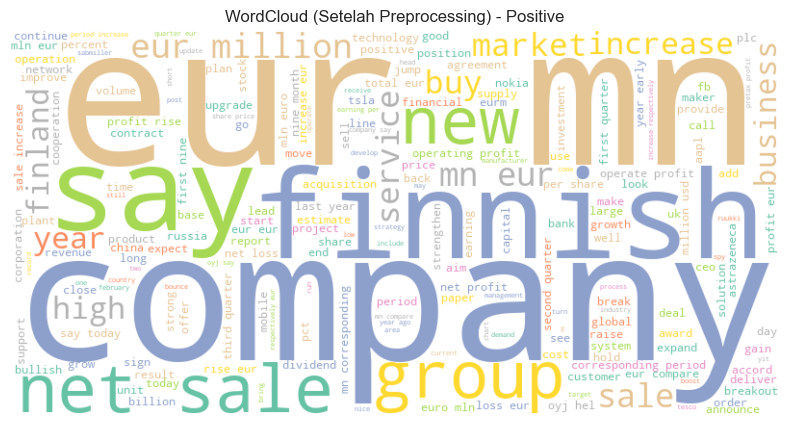

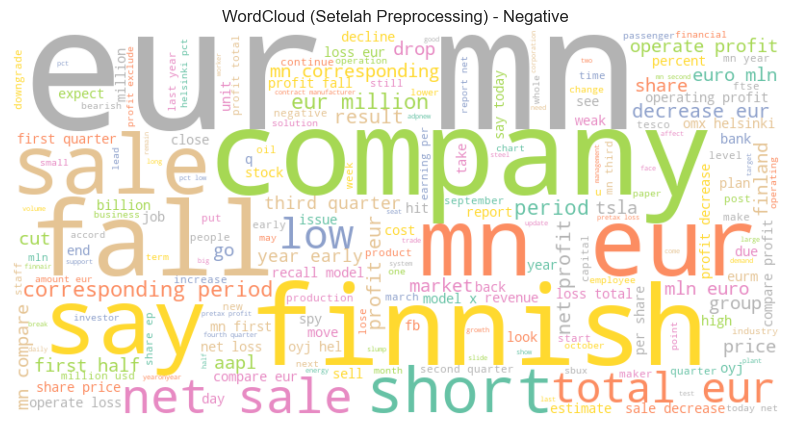

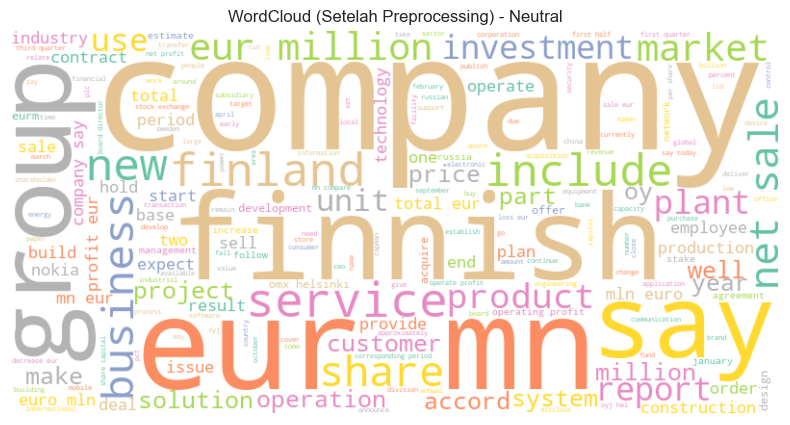

In [52]:
def generate_wordcloud_post_preprocessing(sentiment_label, df):
    text = ' '.join(df[df['Sentiment'] == sentiment_label]['lemmatized_text'].astype(str))
        
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Set2'
    ).generate(text)
        
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud (Setelah Preprocessing) - {sentiment_label.capitalize()}')
    plt.show()

# Visualisasikan WordCloud setelah preprocessing untuk setiap label sentimen
for label in df['Sentiment'].unique():
    generate_wordcloud_post_preprocessing(label, df)

Hasil visualisasi WordCloud setelah dilakukan preprocessing lanjutan menunjukkan bahwa setiap kategori sentimen negatif, netral, dan positif memiliki distribusi kata-kata yang mencerminkan karakteristik semantiknya secara lebih tajam. Pada kategori negatif, kata-kata seperti *fall*, *short*, *loss*, *low*, *total*, dan *decrease* muncul dengan jelas, menggambarkan kondisi keuangan yang merugi, menurun, atau bermasalah. Kata-kata tersebut memberikan sinyal sentimen negatif yang kuat, yang seringkali diasosiasikan dengan berita penurunan pendapatan, nilai saham, atau kinerja operasional.

Sementara itu, kategori netral didominasi oleh kata-kata yang bersifat informatif dan deskriptif seperti *company*, *group*, *service*, *business*, *plant*, dan *system*. Kata-kata ini mencerminkan penyampaian informasi objektif dalam laporan atau berita perusahaan, tanpa adanya muatan emosi atau penilaian nilai. Hal ini sesuai dengan karakter umum headline netral yang menjelaskan aktivitas bisnis, struktur organisasi, atau pengumuman umum lainnya.

Pada kategori positif, muncul kata-kata seperti *increase*, *growth*, *rise*, *improve*, *good*, dan *profit*, yang secara konsisten merepresentasikan pencapaian, keberhasilan finansial, atau optimisme pasar. Kehadiran kata-kata seperti *acquisition*, *buy*, dan *expand* juga menunjukkan indikasi perkembangan perusahaan ke arah yang positif.

Namun, hasil WordCloud ini juga menunjukkan bahwa kata-kata tertentu seperti *eur*, *mn*, *mln*, dan *euro* mendominasi di ketiga kategori tanpa memberikan nilai informatif yang berarti bagi analisis sentimen itu sendiri. Maka dari itu, akan dilakukan normalisasi lanjutan terhadap istilah keuangan (seperti menyatukan mn, mln, dan million menjadi satu bentuk). Langkah ini bertujuan untuk menyederhanakan variasi kata, mengurangi redundansi, dan meningkatkan kualitas representasi fitur teks dalam tahap pemodelan berikutnya, sehingga analisis sentimen dapat dilakukan secara lebih tajam dan efisien.

### Normalisasi Istilah Keuangan

In [53]:
def normalize_financial_terms(text):
    # Normalisasi satuan jutaan → 'million'
    text = re.sub(r'\bmln\b|\bmn\b|\bmillion\b', 'million', text)

    # Normalisasi mata uang euro → 'euro'
    text = re.sub(r'\beur\b|\beuro\b', 'euro', text)

    return text

df['final_text'] = df['lemmatized_text'].apply(normalize_financial_terms)

### WordCloud Final setelah Normalisai

Setelah dilakukan normalisasi istilah keuangan yang mendominasi pada hasil wordcloud sebelumnya, dilakukan pengecekan ulang menggunakan wordcloud lagi.

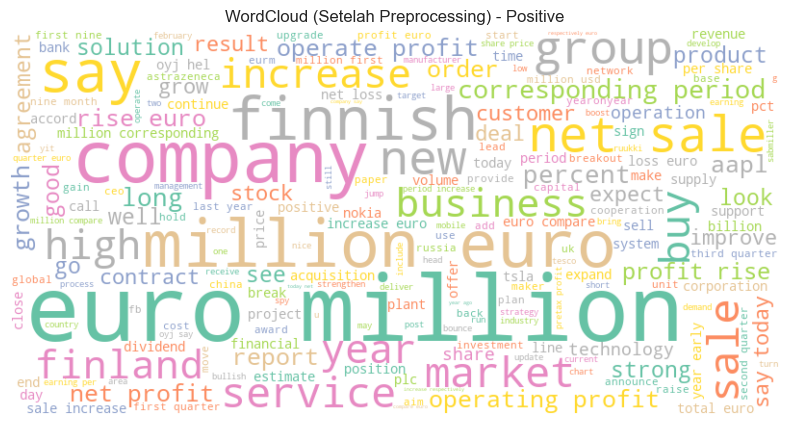

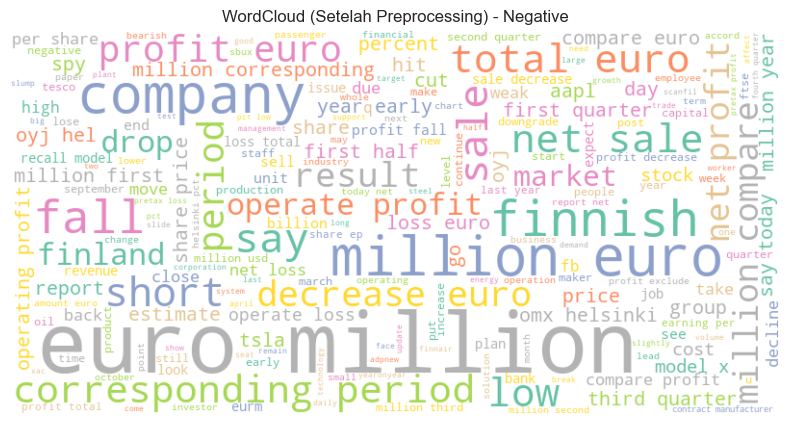

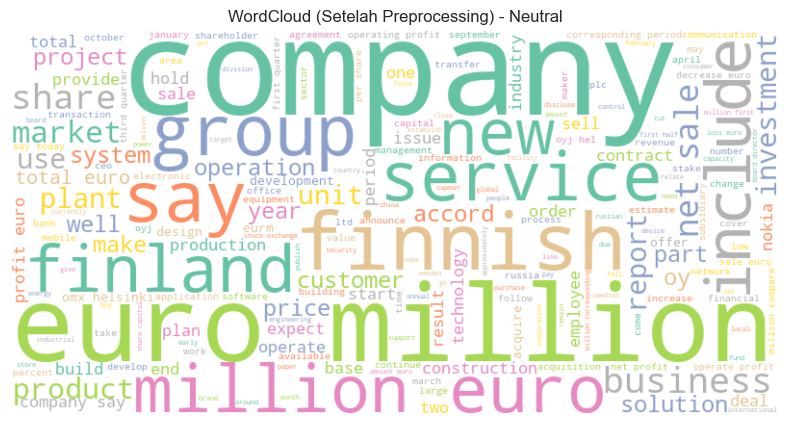

In [54]:
def generate_wordcloud_post_preprocessing(sentiment_label, df):
    text = ' '.join(df[df['Sentiment'] == sentiment_label]['final_text'].astype(str))
        
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Set2'
    ).generate(text)
        
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud (Setelah Preprocessing) - {sentiment_label.capitalize()}')
    plt.show()

# Visualisasikan WordCloud setelah preprocessing untuk setiap label sentimen
for label in df['Sentiment'].unique():
    generate_wordcloud_post_preprocessing(label, df)

Setelah dilakukan normalisasi istilah keuangan seperti menyatukan bentuk variasi *mn*, *mln*, dan *million* menjadi satu istilah “million”, serta eur dan euro menjadi “euro”, WordCloud yang dihasilkan menunjukkan perbaikan dalam representasi kata-kata dominan. Kata-kata seperti million dan euro kini hanya muncul dalam satu bentuk yang konsisten, sehingga mengurangi redundansi visual yang sebelumnya disebabkan oleh bentuk kata yang berbeda-beda tetapi bermakna sama. Hal ini menjadikan tampilan WordCloud lebih bersih dan fokus, serta lebih akurat dalam mencerminkan frekuensi kata sebenarnya di dalam data.

Namun, karena kata-kata seperti euro dan million memang sangat sering digunakan dalam berita finance di semua kategori sentimen, mereka tetap muncul sebagai kata yang sangat dominan di ketiga WordCloud. Dominasi ini tercermin melalui ukuran font yang besar dan distribusi visual yang tersebar, sehingga tampak seperti kata tersebut muncul lebih dari sekali dalam satu plot. Ini bukan kesalahan data atau duplikasi literal, melainkan karakteristik visualisasi dari library WordCloud yang mendistribusikan kata-kata besar secara menyebar untuk mengisi ruang dengan seimbang.

Dengan kata lain, WordCloud berhasil mencerminkan hasil normalisasi dengan baik, karena bentuk-bentuk variasi istilah keuangan kini telah disatukan. Namun, karena frekuensinya tetap tinggi, efek visual pengulangan tetap terjadi.

## Menentukan Kolom Final untuk Pemodelan

Pada tahap ini ditetapkan kolom yang akan digunakan untuk vektorisasi dan model training yaitu kolom `final_text` yang merupakan kolom akhir dari proses preprocessing yang telah dilakukan.

In [ ]:
df['text'] = df['final_text']  #kolom bersih terakhir

## Label Encoding

Pada tahap ini, dilakukan proses label encoding untuk mengubah label sentimen yang semula berbentuk teks, seperti “Positive”, “Neutral”, dan “Negative”, menjadi format numerik yang dapat dikenali oleh model. Untuk keperluan ini digunakan **LabelEncoder** dari scikit-learn karena metode ini efisien dan sederhana untuk kasus klasifikasi dengan satu kolom target. 

In [56]:
# Inisialisasi encoder
le = LabelEncoder()

# Fit dan transform pada seluruh kolom Sentiment
df['label_encoded'] = le.fit_transform(df['Sentiment'])

# Lihat mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping Label:", label_mapping)

Mapping Label: {'negative': 0, 'neutral': 1, 'positive': 2}


Setelah proses encoding dilakukan, label sentimen pada data telah berhasil diubah menjadi nilai numerik, `“Negative” = 0`, `“Neutral” = 1`, dan `“Positive” 2`. Hasil ini akan menjadi target yang digunakan dalam proses pelatihan dan pengujian model. 

## Split Data

Setelah label pada data dikonversi ke bentuk numerik, langkah berikutnya adalah membagi dataset menjadi tiga bagian utama, yaitu training set, validation set, dan test set. Pembagian ini bertujuan untuk memastikan bahwa model yang dibangun dapat dilatih secara efektif (menggunakan training set), divalidasi selama proses pelatihan untuk mencegah overfitting (menggunakan validation set), dan dievaluasi secara objektif terhadap data yang belum pernah dilihat sebelumnya (menggunakan test set). 

In [57]:
X = df['text']
y = df['label_encoded']

# Split train-test dulu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split validasi dari test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 4668, Validation: 584, Test: 584


Setelah proses pembagian dilakukan, dataset berhasil dipecah menjadi tiga bagian dengan distribusi yang seimbang secara stratifikasi. Sebagian besar data (sekitar 80%) digunakan untuk pelatihan model, sementara sisanya dibagi rata untuk keperluan validasi dan pengujian akhir. Hasil pembagian ini akan memastikan bahwa model memiliki cukup data untuk belajar, sekaligus memungkinkan pengujian performa model secara adil dan representatif. Karena distribusi label tetap terjaga di ketiga subset, evaluasi akurasi dan metrik lainnya nanti tidak akan bias akibat perbedaan jumlah data antar kelas.

# **ANN Training**

Model ANN Training dikembangkan sebagai baseline awal untuk membangun sistem klasifikasi sentimen otomatis pada teks berita financial. Pemilihan algoritma **Artificial Neural Network (ANN)** didasarkan pada kemampuannya dalam menangani data teks yang telah diproses ke bentuk vektorisasi, serta fleksibilitas arsitekturnya untuk menyesuaikan kompleksitas data.

## Text Vektorizer

Sebelum teks dapat digunakan sebagai input dalam Artificial Neural Network (ANN), data teks perlu diubah ke dalam bentuk vektor numerik yang disebut text vectorization, dan bertujuan untuk mengonversi kalimat-kalimat dalam kolom text menjadi deretan angka (integer sequence) yang dapat dimasukkan ke layer embedding.

Pada project ini, digunakan TextVectorization karena:

- Terintegrasi langsung dengan pipeline deep learning Keras.

- Mendukung tokenisasi otomatis, filtering, dan padding.

- Memungkinkan mengatur jumlah token unik (`max_tokens`) dan panjang maksimal input (`output_sequence_length`) berdasarkan hasil eksplorasi data sebelumnya.

In [ ]:
# Parameter vectorizer
max_tokens = 10000  # Banyaknya kata unik yang diizinkan (top-N words)
max_len = 50        # Berdasarkan hasil EDA (jumlah kata per kalimat)

# Inisialisasi TextVectorization
vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len
)

# Adaptasi vectorizer ke data training
vectorizer.adapt(X_train)

`max_tokens=10000`  :
Ditentukan agar mencakup sebagian besar kata yang muncul di berita finance, tetapi tetap efisien secara komputasi. Jumlah ini cukup luas untuk menangkap keragaman istilah finansial dan nama entitas tanpa overfitting.

`output_sequence_length=50`:
Berdasarkan analisis panjang kalimat sebelumnya, sebagian besar teks memiliki ≤50 kata. Panjang ini menjaga agar teks panjang tidak terpotong terlalu banyak, sekaligus efisien untuk komputasi.

`Mode int`:
Karena akan digunakan ke dalam layer Embedding pada model ANN, kita butuh token dalam bentuk integer.

## Konversi ke bentuk tensor

In [59]:
# Ubah X_train, X_val, X_test ke tensor vektorisasi
X_train_seq = vectorizer(X_train)
X_val_seq = vectorizer(X_val)
X_test_seq = vectorizer(X_test)

# Tampilkan 1 contoh hasil vektorisasi
print("Contoh hasil vektorisasi:")
print(X_train.iloc[0])
print(X_train_seq[0].numpy())

Contoh hasil vektorisasi:
raute headquartered nastola finland technology company serve wood product industry worldwide
[ 691 1448 1616   14   67    4  686  729   31   88  728    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Handling class imbalanced

Untuk menangani ketidakseimbangan label sentimen dalam data, digunakan metode **class weighting** sebelum proses pelatihan model. Bobot kelas dihitung berdasarkan distribusi `y_train` menggunakan `compute_class_weight`. Pendekatan ini memastikan bahwa model tidak bias terhadap kelas mayoritas dan dapat belajar secara adil terhadap seluruh kategori sentimen.

In [60]:
# Hitung class weight berdasarkan distribusi label
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.261627906976744, 1: 0.6226490596238495, 2: 1.050641458474004}


Bobot yang lebih tinggi diberikan kepada kelas Negative (0) karena jumlahnya paling sedikit, sedangkan Neutral (1) mendapatkan bobot paling rendah karena jumlahnya dominan. Hal ini membantu model untuk tidak bias terhadap kelas mayoritas (Neutral), dan lebih memperhatikan kelas minoritas (Negative).

Dengan menerapkan `class_weight`, diberi kompensasi terhadap ketidakseimbangan distribusi label. Ini sangat penting dalam konteks klasifikasi sentimen, terutama pada data financial yang cenderung netral namun keputusan investor bisa bergantung pada sentimen minoritas seperti Negative news.

## Model Definition

In [67]:
# Parameter utama berdasarkan hasil EDA
embedding_dim = 64      # Ukuran vektor embedding
max_len = 50            # Panjang maksimal sekuens
max_tokens = 10000      # Jumlah kata unik maksimal

# Definisi model
model = Sequential([
    # Layer 1: Embedding
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=max_len),
    
    # Layer 2: GlobalAveragePooling1D
    GlobalAveragePooling1D(),  # Merata-ratakan seluruh token embedding menjadi satu vektor
    
    # Layer 3: Dense Layer 1 + Dropout
    Dense(64, activation='relu'),  # Hidden layer dengan 64 neuron
    Dropout(0.4),                  # Dropout untuk regularisasi (menghindari overfitting)
    
    # Layer 4: Dense Layer 2 + Dropout
    Dense(32, activation='relu'),
    Dropout(0.3),
    
    # Layer 5: Output Layer (3 kelas)
    Dense(3, activation='softmax')  # Output 3 neuron (Negative, Neutral, Positive)
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan default LR
    loss='sparse_categorical_crossentropy',  # Karena label berupa integer
    metrics=['accuracy']  # Metrik utama untuk melihat performa selama training
)

model.build(input_shape=(None, max_len))  # None untuk batch size
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,339 (2.47 MB)

 Trainable params: 646,339 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Arsitektur model ANN ini dirancang berdasarkan hasil eksplorasi data (EDA) yang menunjukkan bahwa sebagian besar kalimat dalam dataset memiliki panjang sekitar 10 hingga 50 kata, dengan vocabulary terbatas pada 10.000 kata unik. Oleh karena itu, digunakan `Embedding` layer sebagai layer pertama untuk mengubah input teks menjadi representasi vektor berdimensi 64, yang cukup untuk menangkap makna semantik dasar dari kata-kata tanpa membebani model. Setelah itu, digunakan `GlobalAveragePooling1D` untuk merata-ratakan representasi seluruh token menjadi satu vektor tetap, yang efektif untuk menangani teks pendek seperti headline dan menjaga efisiensi komputasi. 

Dua hidden layer bertipe `Dense` masing-masing berisi 64 dan 32 neuron dengan aktivasi **ReLU** digunakan untuk menambah kompleksitas non-linear, sementara `Dropout` dengan rasio 0.4 dan 0.3 diterapkan untuk mengurangi risiko overfitting yang umum terjadi pada data teks berukuran kecil hingga sedang. Output layer terdiri dari 3 neuron dengan aktivasi softmax, sesuai dengan jumlah kelas sentimen (negative, neutral, positive) yang ingin diprediksi. Kombinasi komponen ini dipilih karena sesuai dengan karakteristik data, sederhana namun cukup kuat untuk dijadikan baseline, serta fleksibel untuk ditingkatkan di tahap pengembangan selanjutnya.

## Model Training

Pada proses ini dilakukan selama 25 epoch dengan batch size sebesar 32 dan menggunakan skema class weighting untuk mengatasi ketidakseimbangan jumlah data antar kelas. Class weight ini penting untuk mencegah model terlalu fokus pada kelas mayoritas (neutral) dan mengabaikan kelas minoritas seperti negative. Training dilakukan dengan memantau metrik akurasi dan loss pada data pelatihan dan validasi. 

Pemilihan jumlah epoch lebih dari 20 dilakukan agar dapat menangkap pola pelatihan model secara lebih menyeluruh, termasuk untuk melihat apakah model menunjukkan indikasi overfitting, underfitting, atau stabil pada titik tertentu. Dengan jumlah epoch yang cukup panjang, tren performa model menjadi lebih terlihat jelas dan memudahkan dalam menentukan strategi peningkatan performa pada tahap modeling berikutnya.

In [68]:
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=25,
    batch_size=32,
    class_weight=class_weights_dict,
    verbose=1
) 

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.3014 - loss: 1.1077 - val_accuracy: 0.3185 - val_loss: 1.0851
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.3959 - loss: 1.0829 - val_accuracy: 0.1884 - val_loss: 1.1078
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3062 - loss: 1.1092 - val_accuracy: 0.3116 - val_loss: 1.1064
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4639 - loss: 1.0342 - val_accuracy: 0.5445 - val_loss: 0.9519
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5884 - loss: 0.8739 - val_accuracy: 0.6096 - val_loss: 0.8481
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.7048 - loss: 0.6761 - val_accuracy: 0.5497 - val_loss: 0.9123
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7782 - loss: 0.5381 - val_accuracy: 0.6216 - val_loss: 0.8331
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8141 - loss: 0.4481 - va

## Model Evaluation

Untuk mengevaluasi performa model secara menyeluruh, digunakan tiga pendekatan utama, yaitu visualisasi plot, classification report, dan confusion matrix. Visualisasi plot akurasi dan loss digunakan untuk memantau stabilitas proses pelatihan dari waktu ke waktu serta mendeteksi adanya overfitting atau underfitting secara visual. Ini penting karena proyek ini melibatkan data teks yang cukup kompleks dan rawan mengalami overfitting pada model sederhana. Classification report digunakan dengan fokus pada F1-score sebagai metrik utama, karena dataset yang digunakan bersifat imbalanced—di mana metrik akurasi saja tidak cukup mencerminkan performa model terhadap kelas minoritas seperti negative. F1-score memberikan gambaran yang lebih seimbang antara precision dan recall pada masing-masing kelas. Terakhir, confusion matrix digunakan untuk menganalisis pola kesalahan klasifikasi antar kelas secara lebih detail. 

Ketiga hal tersebut relevan dalam konteks proyek analisis sentimen karena model harus mampu membedakan dengan tepat antar kategori positive, neutral, dan negative, yang sering kali memiliki kemiripan secara leksikal. Kombinasi ketiga pendekatan ini memberikan evaluasi yang komprehensif dan sesuai dengan kebutuhan analisis berbasis teks dalam domain finansial.

### Plot Visualisasi

Visualisasi ini membantu melihat apakah model belajar dengan stabil dan apakah ada gap besar antara training dan validation (indikasi overfitting/underfitting).

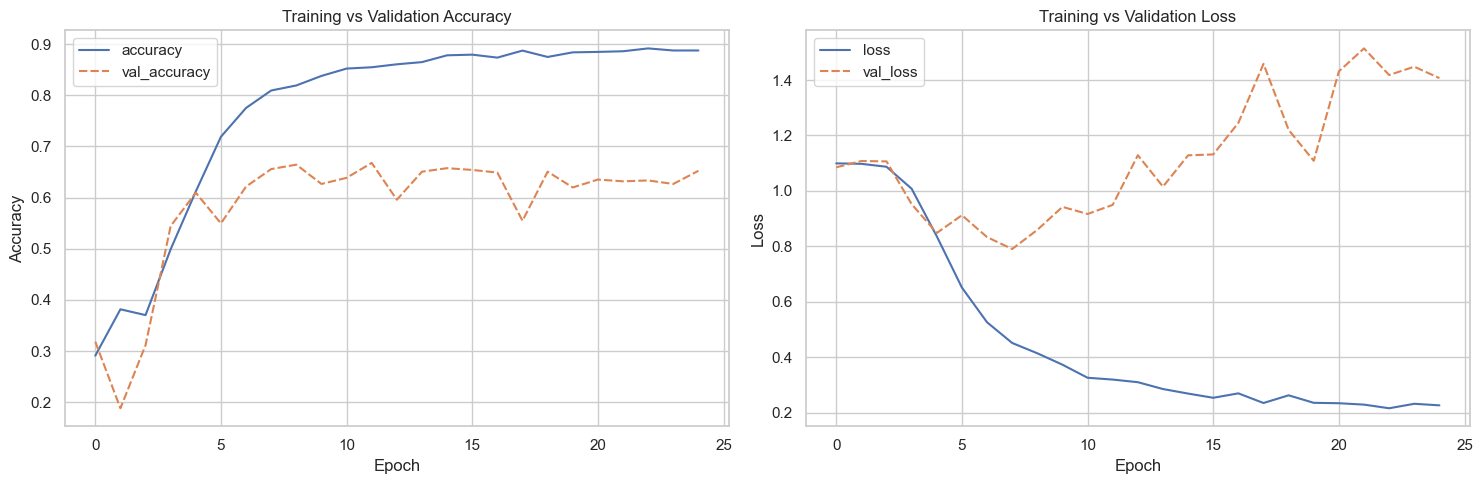

In [72]:
# Buat DataFrame dari history
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Visualisasi hasil pelatihan model ANN menunjukkan adanya perbedaan yang mencolok antara performa pada data pelatihan dan data validasi. Pada grafik sebelah kiri, akurasi pelatihan (training accuracy) meningkat secara konsisten hingga mencapai sekitar 89% pada akhir epoch ke-25, menandakan bahwa model mampu mempelajari pola dalam data pelatihan dengan sangat baik. Namun, akurasi validasi (validation accuracy) hanya meningkat pada beberapa epoch awal dan kemudian stagnan di kisaran 60–67%, tanpa menunjukkan tren peningkatan yang signifikan. Ketimpangan ini menjadi indikasi awal adanya overfitting.

Hal tersebut semakin diperkuat dengan grafik loss pada sisi kanan. Loss pelatihan menurun tajam hingga berada pada nilai yang sangat rendah dan stabil di bawah 0.3, sedangkan loss validasi justru menunjukkan pola sebaliknya, mengalami kenaikan secara bertahap setelah epoch ke-5 dan terus meningkat hingga melebihi nilai 1.4. Tren ini mengindikasikan bahwa meskipun model tampak ‘sempurna’ dalam memahami data pelatihan, performanya pada data validasi justru semakin memburuk seiring waktu. Dengan demikian, **visualisasi ini secara jelas menunjukkan bahwa model mengalami overfitting** cukup parah, yang ditandai dengan celah besar antara akurasi serta divergensi antara nilai loss pelatihan dan validasi.

### Classification Report

In [73]:
# Prediksi data training
y_train_pred = model.predict(X_train_seq)
y_train_pred_classes = tf.argmax(y_train_pred, axis=1)

# Prediksi data testing
y_test_pred = model.predict(X_test_seq)
y_test_pred_classes = tf.argmax(y_test_pred, axis=1)

# Print classification report
print("Train Classification Report")
print(classification_report(y_train, y_train_pred_classes, target_names=le.classes_))

print("\nTest Classification Report")
print(classification_report(y_test, y_test_pred_classes, target_names=le.classes_))

146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Train Classification Report
              precision    recall  f1-score   support

    negative       0.62      0.99      0.76       688
     neutral       1.00      0.84      0.91      2499
    positive       0.99      0.97      0.98      1481

    accuracy                           0.91      4668
   macro avg       0.87      0.94      0.89      4668
weighted avg       0.94      0.91      0.91      4668


Test Classification Report
              precision    recall  f1-score   support

    negative       0.36      0.40      0.38        86
     neutral       0.74      0.70      0.72       313
    positive       0.66      0.69      0.67       185

    accuracy                           0.65       584
   macro avg       0.59      0.59      0.59       584
weighted avg       0.66      0.65      0.66       584



Hasil evaluasi model berdasarkan F1-score menunjukkan bahwa performa model pada data pelatihan sangat tinggi, namun jauh menurun saat diuji pada data baru. Di data pelatihan, model berhasil mengklasifikasikan sentimen dengan sangat baik, terutama pada sentimen neutral dan positive, dengan F1-score masing-masing 0.91 dan 0.98. Bahkan untuk kelas negative yang jumlahnya paling sedikit, model masih mencetak F1-score sebesar 0.76. Hal ini menunjukkan bahwa model sangat memahami data pelatihan.

Namun, saat diuji pada data pengujian, performa model menurun drastis. F1-score untuk kelas negative hanya 0.38, menunjukkan model kesulitan mendeteksi sentimen negatif. F1-score untuk kelas neutral dan positive juga turun menjadi 0.72 dan 0.67. Secara keseluruhan, rata-rata F1-score turun dari 0.89 (pelatihan) menjadi 0.59 (pengujian).

Penurunan ini menunjukkan bahwa **model mengalami overfitting** dimana terlalu menghafal data pelatihan tapi gagal mengenali pola umum yang bisa diterapkan ke data baru. Maka, meskipun akurasi terlihat tinggi di pelatihan, model belum cukup andal untuk digunakan pada data nyata.

### Confussion Matrix

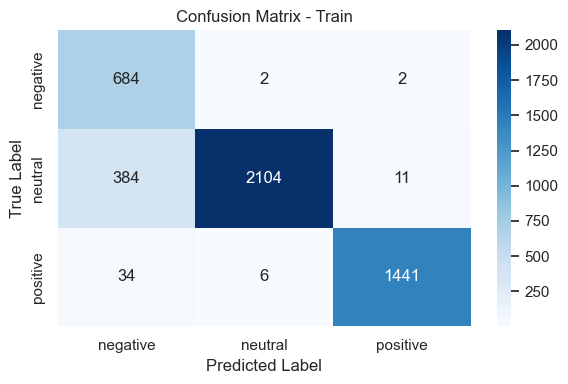

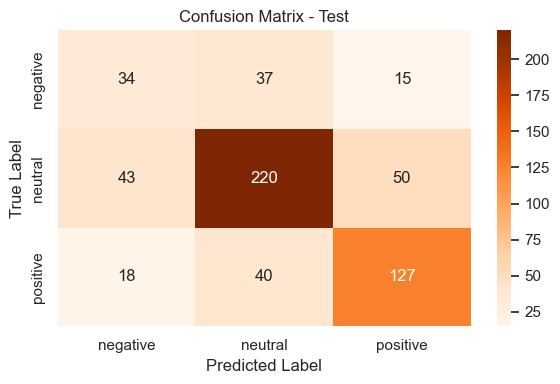

In [75]:
# Buat label nama kelas
labels = le.classes_

# Confusion Matrix - TRAIN
cm_train = confusion_matrix(y_train, y_train_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Confusion Matrix - TEST
cm_test = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Berdasarkan hasil confusion matrix, terlihat bahwa model menunjukkan performa sangat baik pada data pelatihan, namun tidak seimbang ketika diuji pada data pengujian. Pada data pelatihan, hampir semua sampel berhasil diklasifikasikan dengan benar. Kelas negative memiliki akurasi hampir sempurna dengan 684 dari 688 prediksi benar, kelas positive juga tinggi dengan 1441 dari 1481, dan kelas neutral mencapai 2104 dari 2499 meskipun masih terdapat sejumlah kesalahan klasifikasi ke kelas negative. Hal ini menunjukkan bahwa model sangat memahami data pelatihan, tetapi justru cenderung terlalu menyesuaikan diri atau overfitting.

Sebaliknya, pada data pengujian, model mengalami penurunan performa yang signifikan, khususnya dalam membedakan kelas negative dan positive. Dari 86 data negative, hanya 34 yang berhasil diklasifikasikan dengan benar, sementara sebagian besar malah diprediksi sebagai neutral. Demikian pula pada kelas positive, hanya 127 dari 185 yang tepat, dengan sebagian besar sisanya juga salah diklasifikasikan sebagai neutral. Meskipun kelas neutral masih menjadi yang paling banyak diprediksi dengan benar (220 dari 313), banyak juga sampel dari kelas lain yang tertarik ke kelas ini. Hal ini menunjukkan bahwa model cenderung bias terhadap kelas neutral, yang merupakan kelas mayoritas, serta mengalami kesulitan membedakan kalimat yang memiliki nuansa mirip antar sentimen. Secara keseluruhan, confusion matrix memperkuat temuan sebelumnya bahwa **model mengalami overfitting** dan kesulitan dalam generalisasi, terutama dalam mengenali sentimen negative yang jumlahnya lebih sedikit dan sering disalahklasifikasikan.

## Kesimpulan ANN Training

Berdasarkan hasil evaluasi menyeluruh terhadap model ANN yang telah dibangun, dapat disimpulkan bahwa model mampu mencapai performa tinggi pada data pelatihan, namun tidak menunjukkan kemampuan generalisasi yang baik pada data pengujian. Hal ini terlihat dari visualisasi metrik akurasi dan loss yang menunjukkan pola overfitting, serta nilai F1-score dan confusion matrix yang memperlihatkan penurunan drastis saat model diuji pada data baru, khususnya pada kelas negative. Model cenderung bias terhadap kelas mayoritas (neutral) dan kesulitan membedakan kalimat yang mengandung sentimen negatif dan positif yang secara leksikal mungkin memiliki kemiripan. Temuan ini mengindikasikan bahwa arsitektur dan strategi pelatihan yang digunakan masih perlu ditingkatkan agar model dapat bekerja lebih stabil di luar data pelatihan.

Dari sisi implementasi bisnis, model dengan performa seperti ini berisiko menimbulkan dampak signifikan terhadap pengambilan keputusan berbasis data. Karena tujuan utama model adalah untuk membantu investor dan analis dalam mengidentifikasi persepsi pasar secara otomatis dari teks finansial, performa yang buruk terhadap sentimen negative dapat menyebabkan ketidaktepatan dalam membaca sinyal risiko. Jika model terlalu sering salah mengklasifikasikan berita negatif sebagai neutral atau positive, maka perusahaan atau pengguna akhir bisa gagal mendeteksi potensi ancaman pasar secara dini. Ini dapat menyebabkan kerugian strategis, seperti salah arah dalam alokasi aset, keterlambatan dalam merespons krisis keuangan, hingga pengambilan keputusan investasi yang tidak akurat. Oleh karena itu, peningkatan performa model sangat penting sebelum model ini dapat diandalkan dalam sistem otomatis yang mendukung proses analitik dan pengambilan keputusan keuangan.


# **ANN Improvement**

Sebagai langkah lanjutan dari hasil evaluasi pada tahap ANN Training, model ANN Improved ini dirancang untuk mengatasi berbagai keterbatasan yang sebelumnya ditemukan, khususnya masalah overfitting dan rendahnya kemampuan generalisasi model terhadap data baru. Berdasarkan hasil visualisasi dan evaluasi metrik sebelumnya, model awal terlalu fokus pada data pelatihan dan tidak cukup fleksibel dalam mengenali pola sentimen pada data pengujian, terutama pada kelas minoritas seperti negative. Oleh karena itu, pada tahap perbaikan ini, dilakukan penyesuaian arsitektur dan strategi pelatihan untuk menghasilkan model yang lebih stabil, efisien, dan adaptif terhadap data di luar pelatihan.

Untuk memperbaiki performa tersebut, digunakan arsitektur baru berbasis Sequential API yang lebih ringan namun diperkuat dengan beberapa komponen tambahan. Model ini masih menggunakan `Embedding` layer untuk menangkap representasi semantik dari teks, namun ditingkatkan dengan penambahan `Dropout` layer yang lebih agresif untuk memperkuat regularisasi dan mencegah overfitting. Selain itu, digunakan callback `EarlyStopping` untuk menghentikan pelatihan secara otomatis ketika performa validasi mulai menurun, sehingga model tidak belajar terlalu lama dan kehilangan kemampuan generalisasi. Pemilihan ukuran layer juga disesuaikan untuk menjaga keseimbangan antara kapasitas dan efisiensi. Dengan pendekatan ini, diharapkan model dapat mencapai performa yang lebih baik secara menyeluruh—baik dari sisi akurasi, f1-score, maupun waktu pelatihan.

Berikut adalah definisi arsitektur model ANN Improved:

## Model Definition

In [81]:
# Parameter utama
embedding_dim = 64
max_len = 50
max_tokens = 10000

# Definisi model improved
model_improved = Sequential([
    Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # Multi-class output
])

# Kompilasi model
model_improved.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback untuk mencegah overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Lihat ringkasan model
model_improved.build(input_shape=(None, max_len))
model_improved.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,659 (2.45 MB)

 Trainable params: 642,659 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Untuk meningkatkan performa model dari tahap ANN Training, dilakukan sejumlah modifikasi signifikan pada arsitektur dan strategi pelatihan. Perubahan utama terletak pada penyederhanaan struktur hidden layer dan penambahan mekanisme regularisasi yang lebih kuat. Model ANN Improved ini tetap memanfaatkan `Embedding` layer dengan dimensi 64 untuk menangkap makna semantik dari token teks, namun arsitektur selanjutnya dibuat lebih ringan dan efisien dengan hanya menggunakan dua hidden layer berukuran 32 dan 16 neuron. Hal ini dilakukan untuk mengurangi risiko overfitting yang teridentifikasi pada model sebelumnya, tanpa mengorbankan kemampuan representatif dari model.

Selain itu, ditambahkan dua `Dropout` layer dengan tingkat dropout yang lebih tinggi (0.5 dan 0.4) untuk memaksa model belajar secara lebih robust dan tidak terlalu mengandalkan pola-pola tertentu dari data pelatihan. Strategi ini secara langsung bertujuan memperkuat kemampuan generalisasi terhadap data baru. Sebagai tambahan, digunakan callback `EarlyStopping` yang memonitor metrik `val_loss` selama proses pelatihan. Callback ini secara otomatis menghentikan pelatihan jika performa validasi tidak membaik dalam 3 epoch berturut-turut, dan mengembalikan bobot terbaik selama proses training. Hal ini membantu menghindari pembelajaran berlebihan (overfitting) yang tidak membawa manfaat terhadap performa akhir. Dengan kombinasi arsitektur yang lebih ramping, dropout agresif, dan early stopping, model ini dirancang untuk memberikan hasil yang lebih seimbang, baik dari segi metrik maupun efisiensi pelatihan.

## Model Training

In [82]:
# Training model improved
history_improved = model_improved.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=25,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3280 - loss: 1.1049 - val_accuracy: 0.1507 - val_loss: 1.1016
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3041 - loss: 1.1023 - val_accuracy: 0.1473 - val_loss: 1.1069
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2687 - loss: 1.1022 - val_accuracy: 0.3185 - val_loss: 1.0744
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3099 - loss: 1.0895 - val_accuracy: 0.3151 - val_loss: 1.0914
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.3574 - loss: 1.0840 - val_accuracy: 0.4966 - val_loss: 1.0679
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3958 - loss: 1.0563 - val_accuracy: 0.4692 - val_loss: 1.0367
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4460 - loss: 1.0127 - val_accuracy: 0.4897 - val_loss: 1.0232
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5344 - loss: 0.9130 - val_ac

## Model Evaluation

### Plot Visualisasi

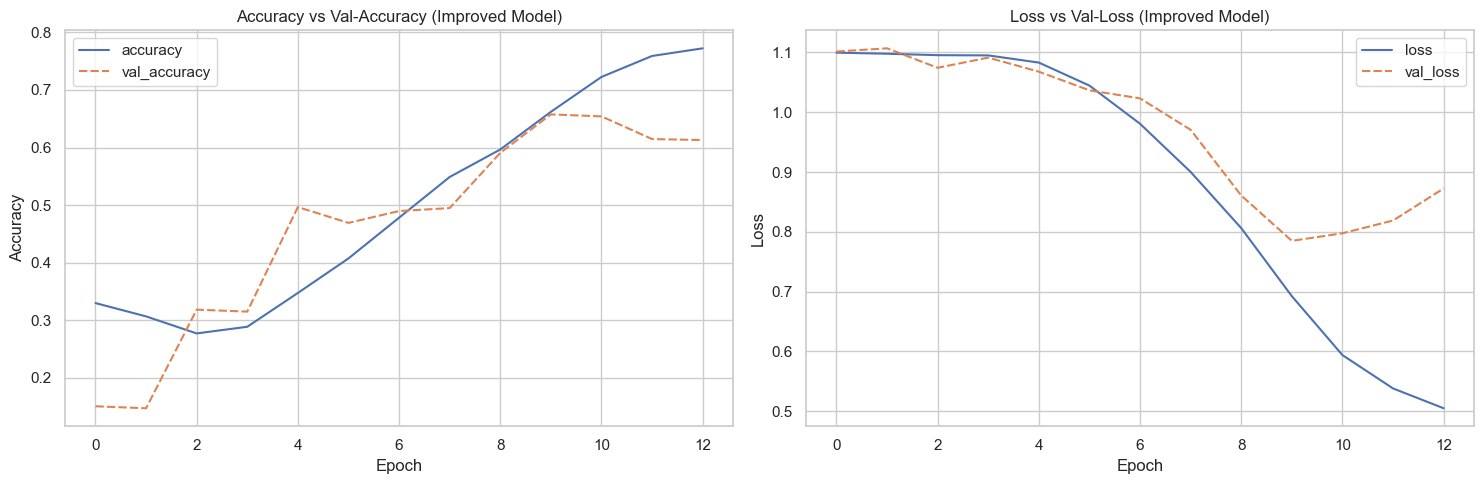

In [ ]:
# Buat DataFrame dari hasil training
hist_improved_df = pd.DataFrame(history_improved.history)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=hist_improved_df[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=hist_improved_df[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss (Improved Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Visualisasi performa model ANN Improved menunjukkan adanya perbaikan dibandingkan model sebelumnya. Grafik akurasi (kiri) memperlihatkan bahwa baik akurasi pelatihan (training accuracy) maupun akurasi validasi (validation accuracy) mengalami peningkatan yang lebih stabil dari epoch ke epoch. Meskipun terdapat sedikit fluktuasi, akurasi validasi mencapai nilai sekitar 62% dan relatif mendekati akurasi pelatihan yang mencapai 78% di akhir pelatihan. Berbeda dengan model sebelumnya yang menunjukkan celah besar antara akurasi pelatihan dan validasi, grafik ini menunjukkan gap yang lebih kecil, yang menandakan bahwa **overfitting telah berhasil dikurangi.**

Sementara itu, grafik loss (kanan) juga menunjukkan pola yang lebih sehat. Loss pada data pelatihan menurun secara konsisten, dan penurunan loss pada data validasi mengikuti tren yang sama hingga sekitar epoch ke-9. Setelah titik tersebut, `val_loss` mulai sedikit meningkat, tetapi tidak drastis seperti pada model sebelumnya. Ini menunjukkan bahwa penggunaan `EarlyStopping` berhasil menghentikan pelatihan sebelum model mulai overfit secara signifikan. Selain itu, dropout yang lebih tinggi juga membantu dalam regularisasi selama proses pelatihan.

Secara keseluruhan, visualisasi ini mengindikasikan bahwa perbaikan arsitektur dan strategi pelatihan—termasuk penggunaan callback dan pengaturan dropout yang lebih optimal—telah menghasilkan model yang lebih stabil dan mampu belajar dengan generalisasi yang lebih baik terhadap data validasi. Hal ini memberikan sinyal positif bahwa model improved memiliki potensi lebih tinggi untuk digunakan dalam konteks prediksi sentimen di dunia nyata.

### Classification Report

In [84]:
# Prediksi train & test
y_train_pred_improved = model_improved.predict(X_train_seq)
y_test_pred_improved = model_improved.predict(X_test_seq)

y_train_pred_classes = tf.argmax(y_train_pred_improved, axis=1)
y_test_pred_classes = tf.argmax(y_test_pred_improved, axis=1)

# Report
print("Train Classification Report (Improved)")
print(classification_report(y_train, y_train_pred_classes, target_names=le.classes_))

print("\nTest Classification Report (Improved)")
print(classification_report(y_test, y_test_pred_classes, target_names=le.classes_))

146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train Classification Report (Improved)
              precision    recall  f1-score   support

    negative       0.55      0.90      0.68       688
     neutral       0.90      0.80      0.85      2499
    positive       0.91      0.80      0.85      1481

    accuracy                           0.82      4668
   macro avg       0.78      0.83      0.79      4668
weighted avg       0.85      0.82      0.82      4668


Test Classification Report (Improved)
              precision    recall  f1-score   support

    negative       0.36      0.50      0.42        86
     neutral       0.75      0.75      0.75       313
    positive       0.75      0.62      0.68       185

    accuracy                           0.67       584
   macro avg       0.62      0.62      0.62       584
weighted avg       0.70      0.67      0.68       584



Berdasarkan classification report, model ANN Improved menunjukkan peningkatan performa yang cukup signifikan dibandingkan model sebelumnya. Pada data pelatihan, F1-score mengalami penurunan dari model sebelumnya yang overfit, namun hal ini justru mencerminkan performa yang lebih realistis dan generalisasi yang lebih baik. Model mampu mempertahankan F1-score yang cukup stabil pada seluruh kelas, yaitu 0.68 untuk negative, serta masing-masing 0.85 untuk neutral dan positive. Nilai rata-rata F1-score makro berada di angka 0.79, dan weighted avg di angka 0.82, menunjukkan bahwa model sudah tidak lagi terlalu bias terhadap kelas mayoritas (neutral), dan lebih seimbang dalam mengenali seluruh kategori sentimen.

Pada data pengujian, model juga menunjukkan perbaikan. F1-score untuk kelas negative meningkat menjadi 0.42 dari sebelumnya 0.38, sementara kelas neutral dan positive mencetak skor masing-masing 0.75 dan 0.68. Meskipun skor kelas negative masih rendah, ini merupakan kemajuan karena model sebelumnya sangat buruk dalam mendeteksi kelas tersebut. Nilai rata-rata F1-score makro meningkat dari 0.59 menjadi 0.62, sedangkan weighted avg meningkat dari 0.66 menjadi 0.68. Hal ini menunjukkan bahwa model kini lebih stabil dalam melakukan klasifikasi dan memiliki kemampuan generalisasi yang lebih baik terhadap data baru.

Dengan kata lain, meskipun belum sempurna, **model ANN Improved berhasil mengurangi overfitting** dan memperbaiki kemampuan model dalam mendeteksi ketiga kelas secara lebih seimbang. Ini adalah indikasi positif bahwa arsitektur dan strategi pelatihan yang diubah telah berdampak langsung terhadap performa yang lebih baik dan lebih dapat diandalkan.


### Confussion Matrix

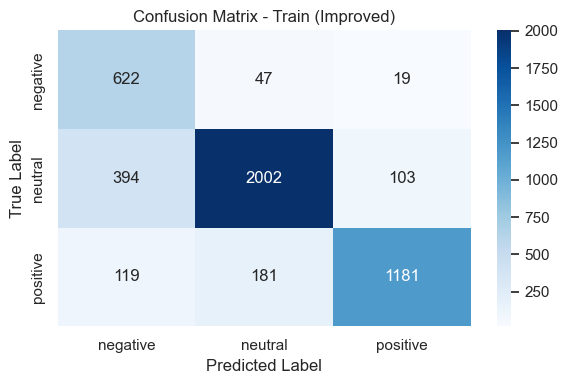

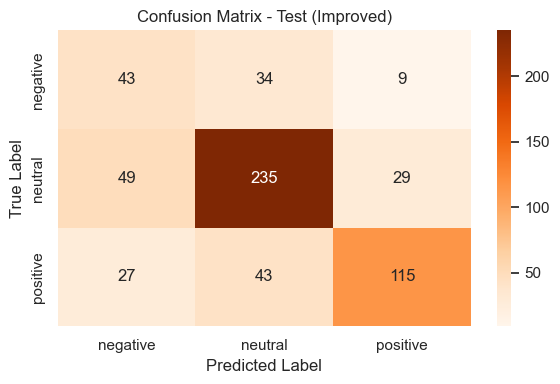

In [85]:
labels = le.classes_

# Train Confusion Matrix
cm_train_improved = confusion_matrix(y_train, y_train_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train_improved, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Train (Improved)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Test Confusion Matrix
cm_test_improved = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_improved, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test (Improved)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Pada data pelatihan, model menunjukkan kemampuan klasifikasi yang cukup baik namun tetap realistis, tidak lagi terlihat “sempurna” seperti pada model sebelumnya. Sebanyak 622 dari 688 data negative berhasil diklasifikasikan dengan benar, meskipun masih ada 47 yang dikira neutral dan 19 sebagai positive. Kelas neutral juga cukup baik dengan 2002 dari 2499 data diklasifikasikan dengan benar, walaupun masih terdapat kesalahan yang relatif besar ke kelas negative (394 data). Untuk kelas positive, 1181 dari 1481 berhasil dikenali dengan benar, sementara sisanya sebagian besar salah dikira neutral. Meskipun belum sempurna, hasil ini menunjukkan bahwa model sudah mulai lebih seimbang dan tidak terlalu bias terhadap satu kelas tertentu.

Hasil pada data pengujian menunjukkan perbaikan dibandingkan model sebelumnya. Untuk kelas negative, 43 dari 86 data berhasil diklasifikasikan dengan benar, meningkat dari sebelumnya 34. Kesalahan klasifikasi ke neutral masih ada (34 data), namun jumlahnya lebih sedikit. Untuk kelas neutral, model mampu mengenali 235 dari 313 data dengan benar, dan untuk kelas positive, 115 dari 185 data diklasifikasikan dengan benar, meningkat juga dari sebelumnya. Sebagian besar kesalahan prediksi masih terjadi antara kelas neutral dan positive, namun penyebarannya tidak seburuk sebelumnya. Ini menunjukkan bahwa model improved lebih seimbang dan tidak terlalu condong pada satu label, walaupun kesalahan antar kelas masih cukup umum terjadi.

Secara keseluruhan, **confusion matrix ini memperkuat hasil evaluasi sebelumnya bahwa model improved berhasil mengurangi overfitting**, meningkatkan kemampuan deteksi pada kelas minoritas (negative), dan menghasilkan klasifikasi yang lebih merata. Meskipun beberapa kelas masih mengalami misclassifikasi, terutama pada neutral yang cenderung tumpang tindih dengan dua kelas lainnya, perbaikan ini merupakan langkah positif menuju model yang lebih dapat diandalkan di lingkungan nyata.

## Kesimpulan ANN Improved

Model ANN Improved menunjukkan peningkatan yang jelas dibandingkan model sebelumnya. **Overfitting berhasil dikurangi** berkat penggunaan `dropout` dan callback `EarlyStopping`, sehingga model mampu belajar lebih stabil dan seimbang. F1-score meningkat di semua kelas, khususnya kelas negative, yang sebelumnya sulit dikenali. Akurasi validasi dan hasil confusion matrix juga menunjukkan bahwa model lebih adil dalam mengklasifikasikan ketiga kategori sentimen.

Dari sisi bisnis, peningkatan ini penting karena kemampuan mengenali sentimen negatif secara lebih akurat dapat membantu investor mendeteksi risiko lebih cepat. Jika model sebelumnya digunakan, informasi penting bisa terlewat dan berpotensi menyebabkan keputusan yang merugikan. Dengan performa yang lebih seimbang dan generalisasi yang lebih baik, model improved layak digunakan untuk tahap deployment.

# Model Saving

In [ ]:
# Simpan model ke file .h5
model_improved.save('model_sentiment_ann.h5')

# Simpan LabelEncoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

# Bungkus TextVectorization ke dalam model Sequential
vectorizer_model = tf.keras.Sequential([vectorizer])

# Simpan model vectorizer ke file .keras
vectorizer_model.save('text_vectorizer_model.keras')  

c:\Users\USER\nlp_env\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


# **Kesimpulan**

Project ini bertujuan membangun model klasifikasi sentimen pada headline berita keuangan menggunakan pendekatan **Artificial Neural Network (ANN)**. Dari hasil eksplorasi data awal (EDA), ditemukan bahwa distribusi sentimen cukup tidak seimbang dengan dominasi label neutral, serta banyaknya kemunculan istilah finansial seperti million, euro, dan profit di seluruh kategori sentimen. Hal ini menuntut pendekatan preprocessing yang cermat, termasuk normalisasi istilah keuangan, lemmatization, dan penghapusan stopwords agar model tidak bias terhadap kata-kata yang terlalu umum.

Pada tahap **ANN Training**, model awal menunjukkan akurasi pelatihan yang tinggi (91%) namun performa pada data uji jauh lebih rendah (65%), mengindikasikan overfitting. Analisis f1-score dan confusion matrix juga menunjukkan bahwa model kurang mampu mengenali label negative secara akurat. Untuk mengatasi hal ini, dilakukan perbaikan arsitektur di tahap **ANN Improved**. Model ini menggunakan `dropout` yang lebih agresif dan callback `EarlyStopping` sehingga performa validasi lebih stabil. Hasilnya, meskipun akurasi hanya meningkat sedikit menjadi 67%, f1-score menunjukkan peningkatan keseimbangan performa di seluruh kelas dan tren overfitting berhasil ditekan.

**Kelebihan Model:**

- Proses preprocessing disesuaikan dengan konteks keuangan, termasuk normalisasi istilah khusus yang memperkuat kualitas input.

- Model ANN mampu belajar representasi semantik secara end-to-end tanpa proses feature engineering manual.

- Penggunaan stratified split menjaga distribusi label tetap proporsional di seluruh subset data, mendukung evaluasi yang adil.

**Kekurangan Model:**

- Model masih mengalami kesulitan dalam mengklasifikasikan label negative, terutama karena distribusi data yang tidak seimbang.

- Belum dilakukan hyperparameter tuning secara komprehensif.

- Belum memanfaatkan pendekatan arsitektur lanjutan seperti attention mechanism atau pretrained transformer yang lebih kontekstual.

**Saran Lanjutan:**

- Perluasan Dataset: Perlu menambah jumlah data terutama untuk label minoritas, dengan teknik seperti penambahan sumber berita baru atau text augmentation.

- Eksplorasi Model Lanjutan: Model berbasis LSTM, GRU, atau BERT dapat dicoba untuk memahami konteks kalimat yang lebih kompleks dan meningkatkan akurasi prediksi.

- Optimasi Hyperparameter: Penggunaan teknik seperti GridSearchCV dapat meningkatkan konfigurasi arsitektur ANN yang digunakan.

- Penambahan Interpretabilitas: Dengan tools seperti SHAP atau LIME, model dapat dijadikan lebih transparan dan dapat dipercaya oleh pengguna akhir seperti analis keuangan.

**Implikasi Bisnis:**

Jika model ini diimplementasikan dalam sistem pemantauan berita keuangan secara real-time, maka organisasi atau investor dapat mengidentifikasi sentimen pasar lebih cepat dan efisien, menggantikan interpretasi manual yang lambat dan bias. Misalnya, lonjakan berita negative tentang perusahaan tertentu dapat segera memicu peringatan risiko atau pengambilan keputusan portofolio. Sebaliknya, jika model belum akurat, terutama dalam mengklasifikasikan sentimen negatif, maka keputusan berbasis model dapat keliru dan menimbulkan kerugian finansial. Oleh karena itu, meskipun model saat ini sudah cukup layak sebagai baseline, perbaikan lanjutan tetap diperlukan sebelum digunakan dalam skala produksi.

Secara keseluruhan, proyek ini telah memberikan pondasi yang kuat secara teknis dan strategis untuk pengembangan sistem analitik sentimen yang bermanfaat di industri keuangan. Model ANN ini tidak hanya membuktikan kelayakan pendekatan machine learning dalam klasifikasi opini pasar, tetapi juga menunjukkan bagaimana penggabungan analisis data dan praktik bisnis dapat mendukung keputusan yang lebih cerdas dan cepat.